In [1]:
#Save con Nodos
import os
from keras.models import load_model
import itertools
from matplotlib import pyplot as plt
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import os, sys
dirpath = os.getcwd().split("code")[0]+"code/"
sys.path.append(dirpath)
from sklearn.utils import class_weight
import numpy as np

from evaluation import calculate_metrics
from sklearn.metrics import confusion_matrix,accuracy_score
import pandas as pd
from keras.regularizers import l2
from keras.activations import tanh
from keras.models import Sequential
from keras.layers import *
from keras.losses import categorical_crossentropy,binary_crossentropy
from keras.optimizers import SGD,Adam
from keras.callbacks import LearningRateScheduler
from keras import optimizers
from keras import backend as K
from time import time
import random
from random import shuffle,seed
from sklearn.metrics import classification_report
import math
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler,EarlyStopping,ReduceLROnPlateau
from keras.backend import eval



Using TensorFlow backend.


In [2]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix
from sklearn.preprocessing import normalize
import time

def plot_confusion_matrix(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
    
def plot_state_matrix(cm, states,title='Transition Probabilities',cmap=plt.cm.Blues):
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(states))
    plt.xticks(tick_marks, states)
    plt.yticks(tick_marks, states)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2. else "black")
    plt.ylabel('Origin state')
    plt.xlabel('Destination state')
    plt.tight_layout()

In [3]:
fold = "../../KOI_Data/"
df_sets = pd.read_csv(fold+"/koi_sets_unb.csv") 
mask_train = (df_sets["Set"] == "Train").values
mask_test = (df_sets["Set"] == "Test").values
mask_unlabeled = (df_sets["Set"] == "Unlabeled").values
df_sets.head()

,KOI Name,Set
0,K00889.01,Test
1,K01009.01,Train
2,K07621.01,Train
3,K06252.01,Train
4,K00958.01,Unlabeled


In [4]:
df_meta = pd.read_csv(fold+"/koi_metadata.csv")
df_meta_train = df_meta[mask_train]
df_meta_test = df_meta[mask_test]
df_meta_unb = df_meta[mask_unlabeled]

df_meta_train.head()

,KOI Name,NExScI Disposition,Kepler Name,Period,Time of Transit Epoch,First Transit Time (BJD),Impact Parameter,Duration,Transit Depth,r/R,...,Teff,log(g),Metallicity,Stellar Radius,Stellar Mass,Max single event sigma,Max Multievent sigma,Transit Model SNR,KOI count,Transit Number
1,K01009.01,FALSE POSITIVE,NaN,5.092465,357.53594,2455190.536,0.161,3.65900,254.0,0.014,...,5037.0,4.547,-0.20,0.751,0.727,3.648,15.175,17.1,1,225
2,K07621.01,FALSE POSITIVE,NaN,275.073650,315.24860,2455148.249,0.595,3.37000,228.9,0.014,...,5604.0,4.226,-0.12,1.187,0.864,5.909,8.012,7.5,1,4
3,K06252.01,FALSE POSITIVE,NaN,8.460439,133.77449,2454966.774,1.061,4.73492,76412.9,0.478,...,5951.0,4.638,-1.06,0.702,0.796,452.526,3704.503,1797.4,1,164
6,K04162.01,FALSE POSITIVE,NaN,0.539366,131.97457,2454964.975,0.988,5.43400,145.0,0.016,...,6341.0,3.301,-0.10,5.302,2.050,4.847,9.076,57.6,1,1239
9,K00998.01,FALSE POSITIVE,NaN,161.788327,214.03900,2455047.039,0.267,5.31000,87750.0,0.273,...,6018.0,4.327,0.18,1.212,1.142,341.666,806.993,704.5,1,9


In [5]:
kois_train=df_meta_train['KOI Name'].values
labels_train=df_meta_train['NExScI Disposition'].values
kois_val=df_meta_test['KOI Name'].values
labels_val=df_meta_test['NExScI Disposition'].values
kois_test=df_meta_unb['KOI Name'].values
labels_test=df_meta_unb['NExScI Disposition'].values

In [6]:
labels_train[:5]

array(['FALSE POSITIVE', 'FALSE POSITIVE', 'FALSE POSITIVE',
       'FALSE POSITIVE', 'FALSE POSITIVE'], dtype=object)

In [7]:
def to_int(labels):
    y_true=[]
    for y in labels:
        if y=='CONFIRMED':
            y_true.append(1)
        else:
            y_true.append(0)
    return y_true

In [10]:
y_train_1=to_int(labels_train)
y_train_2=to_int(labels_train)
y_val_1=to_int(labels_val)
y_val_2=to_int(labels_val)
y_train = y_train_1 + y_train_2
y_val = y_val_1+y_val_2

In [11]:
folder_fp='/work/work_teamEXOPLANET/MTF/falsos_positivos/'
folder_c='/work/work_teamEXOPLANET/MTF_gabo/'
falsos=os.listdir(folder_fp)
confirmed=os.listdir(folder_c+'confirmados')
candidates=os.listdir(folder_c+'candidatos')
#load data
x_train=[]
i=0
for koi in kois_train:
    print ("Cargando objeto", koi, 'con ientificador',i)
    if labels_train[i]=='FALSE POSITIVE':
        x_train.append(np.load(folder_fp+koi+'.npy'))
    else:
        x_train.append(np.load(folder_c+'confirmados/'+koi+'.npy'))
    i+=1

    
    
folder_fp='/work/work_teamEXOPLANET/MTF_gabo/falsos_positivos_2/'
folder_c='/work/work_teamEXOPLANET/MTF_gabo/'
falsos=os.listdir(folder_fp)
confirmed=os.listdir(folder_c+'confirmados')
candidates=os.listdir(folder_c+'candidatos')
#load data
i=0
for koi in kois_train:
    print ("Cargando objeto", koi, 'con ientificador',i)
    if labels_train[i]=='FALSE POSITIVE':
        x_train.append(np.load(folder_fp+koi+'.npy'))
    else:
        x_train.append(np.load(folder_c+'confirmados/'+koi+'.npy'))
    i+=1
 

Cargando objeto K01009.01 con ientificador 0
Cargando objeto K07621.01 con ientificador 1
Cargando objeto K06252.01 con ientificador 2
Cargando objeto K04162.01 con ientificador 3
Cargando objeto K00998.01 con ientificador 4
Cargando objeto K00992.01 con ientificador 5
Cargando objeto K00982.01 con ientificador 6
Cargando objeto K03924.01 con ientificador 7
Cargando objeto K07623.01 con ientificador 8
Cargando objeto K00362.01 con ientificador 9
Cargando objeto K03658.01 con ientificador 10
Cargando objeto K00993.01 con ientificador 11
Cargando objeto K00993.02 con ientificador 12
Cargando objeto K00993.03 con ientificador 13
Cargando objeto K01008.01 con ientificador 14
Cargando objeto K04224.01 con ientificador 15
Cargando objeto K04212.01 con ientificador 16
Cargando objeto K01007.01 con ientificador 17
Cargando objeto K04925.01 con ientificador 18
Cargando objeto K07625.01 con ientificador 19
Cargando objeto K04927.01 con ientificador 20
Cargando objeto K01001.01 con ientificador 2

Cargando objeto K01214.01 con ientificador 378
Cargando objeto K02279.02 con ientificador 379
Cargando objeto K08243.01 con ientificador 380
Cargando objeto K07663.01 con ientificador 381
Cargando objeto K03893.01 con ientificador 382
Cargando objeto K02536.01 con ientificador 383
Cargando objeto K03966.01 con ientificador 384
Cargando objeto K01207.01 con ientificador 385
Cargando objeto K07664.01 con ientificador 386
Cargando objeto K08244.01 con ientificador 387
Cargando objeto K00805.01 con ientificador 388
Cargando objeto K03544.01 con ientificador 389
Cargando objeto K03615.01 con ientificador 390
Cargando objeto K00045.01 con ientificador 391
Cargando objeto K00442.01 con ientificador 392
Cargando objeto K00442.02 con ientificador 393
Cargando objeto K00442.03 con ientificador 394
Cargando objeto K01212.01 con ientificador 395
Cargando objeto K07544.01 con ientificador 396
Cargando objeto K07544.02 con ientificador 397
Cargando objeto K02308.01 con ientificador 398
Cargando obje

Cargando objeto K03439.01 con ientificador 587
Cargando objeto K01325.01 con ientificador 588
Cargando objeto K06402.01 con ientificador 589
Cargando objeto K06112.01 con ientificador 590
Cargando objeto K01333.01 con ientificador 591
Cargando objeto K06113.01 con ientificador 592
Cargando objeto K01803.02 con ientificador 593
Cargando objeto K00244.01 con ientificador 594
Cargando objeto K06403.01 con ientificador 595
Cargando objeto K06404.01 con ientificador 596
Cargando objeto K07691.01 con ientificador 597
Cargando objeto K03669.01 con ientificador 598
Cargando objeto K02787.01 con ientificador 599
Cargando objeto K05058.01 con ientificador 600
Cargando objeto K05059.01 con ientificador 601
Cargando objeto K06407.01 con ientificador 602
Cargando objeto K02876.01 con ientificador 603
Cargando objeto K02876.02 con ientificador 604
Cargando objeto K08093.01 con ientificador 605
Cargando objeto K06408.01 con ientificador 606
Cargando objeto K03698.01 con ientificador 607
Cargando obje

Cargando objeto K01664.01 con ientificador 790
Cargando objeto K04018.01 con ientificador 791
Cargando objeto K06473.01 con ientificador 792
Cargando objeto K03453.01 con ientificador 793
Cargando objeto K06474.01 con ientificador 794
Cargando objeto K06122.01 con ientificador 795
Cargando objeto K03743.01 con ientificador 796
Cargando objeto K00820.01 con ientificador 797
Cargando objeto K03290.01 con ientificador 798
Cargando objeto K01873.01 con ientificador 799
Cargando objeto K01873.02 con ientificador 800
Cargando objeto K01561.01 con ientificador 801
Cargando objeto K05108.01 con ientificador 802
Cargando objeto K04658.01 con ientificador 803
Cargando objeto K05109.01 con ientificador 804
Cargando objeto K04088.01 con ientificador 805
Cargando objeto K06477.01 con ientificador 806
Cargando objeto K03272.01 con ientificador 807
Cargando objeto K06479.01 con ientificador 808
Cargando objeto K06481.01 con ientificador 809
Cargando objeto K00404.01 con ientificador 810
Cargando obje

Cargando objeto K05152.01 con ientificador 999
Cargando objeto K06564.01 con ientificador 1000
Cargando objeto K02440.01 con ientificador 1001
Cargando objeto K04199.01 con ientificador 1002
Cargando objeto K06565.01 con ientificador 1003
Cargando objeto K06566.01 con ientificador 1004
Cargando objeto K06567.01 con ientificador 1005
Cargando objeto K02555.01 con ientificador 1006
Cargando objeto K04008.01 con ientificador 1007
Cargando objeto K00408.01 con ientificador 1008
Cargando objeto K00408.02 con ientificador 1009
Cargando objeto K00408.03 con ientificador 1010
Cargando objeto K00408.04 con ientificador 1011
Cargando objeto K00408.05 con ientificador 1012
Cargando objeto K00644.01 con ientificador 1013
Cargando objeto K00188.01 con ientificador 1014
Cargando objeto K00829.01 con ientificador 1015
Cargando objeto K00829.02 con ientificador 1016
Cargando objeto K00829.03 con ientificador 1017
Cargando objeto K00830.01 con ientificador 1018
Cargando objeto K06569.01 con ientificado

Cargando objeto K02983.01 con ientificador 1209
Cargando objeto K06614.01 con ientificador 1210
Cargando objeto K06616.01 con ientificador 1211
Cargando objeto K04100.01 con ientificador 1212
Cargando objeto K02183.01 con ientificador 1213
Cargando objeto K02183.02 con ientificador 1214
Cargando objeto K02183.03 con ientificador 1215
Cargando objeto K01908.01 con ientificador 1216
Cargando objeto K01908.02 con ientificador 1217
Cargando objeto K07736.01 con ientificador 1218
Cargando objeto K08104.01 con ientificador 1219
Cargando objeto K00555.01 con ientificador 1220
Cargando objeto K07737.01 con ientificador 1221
Cargando objeto K00272.01 con ientificador 1222
Cargando objeto K00033.01 con ientificador 1223
Cargando objeto K06620.01 con ientificador 1224
Cargando objeto K00206.01 con ientificador 1225
Cargando objeto K07738.01 con ientificador 1226
Cargando objeto K01956.01 con ientificador 1227
Cargando objeto K03603.01 con ientificador 1228
Cargando objeto K06621.01 con ientificad

Cargando objeto K07761.01 con ientificador 1417
Cargando objeto K00306.01 con ientificador 1418
Cargando objeto K03070.01 con ientificador 1419
Cargando objeto K06662.01 con ientificador 1420
Cargando objeto K03004.01 con ientificador 1421
Cargando objeto K02098.01 con ientificador 1422
Cargando objeto K04087.01 con ientificador 1423
Cargando objeto K06663.01 con ientificador 1424
Cargando objeto K06664.01 con ientificador 1425
Cargando objeto K07763.01 con ientificador 1426
Cargando objeto K03134.01 con ientificador 1427
Cargando objeto K06019.01 con ientificador 1428
Cargando objeto K02343.01 con ientificador 1429
Cargando objeto K08118.01 con ientificador 1430
Cargando objeto K02627.01 con ientificador 1431
Cargando objeto K00659.01 con ientificador 1432
Cargando objeto K04553.01 con ientificador 1433
Cargando objeto K04131.01 con ientificador 1434
Cargando objeto K06667.01 con ientificador 1435
Cargando objeto K03932.01 con ientificador 1436
Cargando objeto K03605.01 con ientificad

Cargando objeto K00094.02 con ientificador 1609
Cargando objeto K00094.03 con ientificador 1610
Cargando objeto K00094.04 con ientificador 1611
Cargando objeto K01231.02 con ientificador 1612
Cargando objeto K04163.01 con ientificador 1613
Cargando objeto K06716.01 con ientificador 1614
Cargando objeto K06717.01 con ientificador 1615
Cargando objeto K01620.01 con ientificador 1616
Cargando objeto K06718.01 con ientificador 1617
Cargando objeto K03705.01 con ientificador 1618
Cargando objeto K03701.01 con ientificador 1619
Cargando objeto K00372.01 con ientificador 1620
Cargando objeto K03284.01 con ientificador 1621
Cargando objeto K02451.01 con ientificador 1622
Cargando objeto K00560.01 con ientificador 1623
Cargando objeto K01790.01 con ientificador 1624
Cargando objeto K02455.01 con ientificador 1625
Cargando objeto K00416.02 con ientificador 1626
Cargando objeto K03818.01 con ientificador 1627
Cargando objeto K08123.01 con ientificador 1628
Cargando objeto K07782.01 con ientificad

Cargando objeto K01732.01 con ientificador 1820
Cargando objeto K02220.03 con ientificador 1821
Cargando objeto K06784.01 con ientificador 1822
Cargando objeto K02681.01 con ientificador 1823
Cargando objeto K02681.02 con ientificador 1824
Cargando objeto K00417.01 con ientificador 1825
Cargando objeto K03305.01 con ientificador 1826
Cargando objeto K08129.01 con ientificador 1827
Cargando objeto K00074.01 con ientificador 1828
Cargando objeto K06787.01 con ientificador 1829
Cargando objeto K01696.01 con ientificador 1830
Cargando objeto K05335.01 con ientificador 1831
Cargando objeto K04413.01 con ientificador 1832
Cargando objeto K02114.01 con ientificador 1833
Cargando objeto K02087.01 con ientificador 1834
Cargando objeto K01370.01 con ientificador 1835
Cargando objeto K06789.01 con ientificador 1836
Cargando objeto K03242.01 con ientificador 1837
Cargando objeto K06790.01 con ientificador 1838
Cargando objeto K04572.01 con ientificador 1839
Cargando objeto K03026.01 con ientificad

Cargando objeto K00238.02 con ientificador 2031
Cargando objeto K03775.01 con ientificador 2032
Cargando objeto K01350.01 con ientificador 2033
Cargando objeto K01700.01 con ientificador 2034
Cargando objeto K00019.01 con ientificador 2035
Cargando objeto K02292.01 con ientificador 2036
Cargando objeto K06034.01 con ientificador 2037
Cargando objeto K02051.01 con ientificador 2038
Cargando objeto K01961.01 con ientificador 2039
Cargando objeto K00456.01 con ientificador 2040
Cargando objeto K00456.02 con ientificador 2041
Cargando objeto K00876.01 con ientificador 2042
Cargando objeto K01979.01 con ientificador 2043
Cargando objeto K00674.01 con ientificador 2044
Cargando objeto K06851.01 con ientificador 2045
Cargando objeto K06852.01 con ientificador 2046
Cargando objeto K06854.01 con ientificador 2047
Cargando objeto K03055.01 con ientificador 2048
Cargando objeto K04536.01 con ientificador 2049
Cargando objeto K06856.01 con ientificador 2050
Cargando objeto K07584.01 con ientificad

Cargando objeto K01840.01 con ientificador 2243
Cargando objeto K02869.01 con ientificador 2244
Cargando objeto K00895.01 con ientificador 2245
Cargando objeto K03322.01 con ientificador 2246
Cargando objeto K06914.01 con ientificador 2247
Cargando objeto K06915.01 con ientificador 2248
Cargando objeto K02778.01 con ientificador 2249
Cargando objeto K01467.01 con ientificador 2250
Cargando objeto K03706.01 con ientificador 2251
Cargando objeto K04038.01 con ientificador 2252
Cargando objeto K03958.01 con ientificador 2253
Cargando objeto K04075.01 con ientificador 2254
Cargando objeto K04415.01 con ientificador 2255
Cargando objeto K00131.01 con ientificador 2256
Cargando objeto K02523.01 con ientificador 2257
Cargando objeto K06163.01 con ientificador 2258
Cargando objeto K04903.01 con ientificador 2259
Cargando objeto K05427.01 con ientificador 2260
Cargando objeto K02247.01 con ientificador 2261
Cargando objeto K08145.01 con ientificador 2262
Cargando objeto K08145.02 con ientificad

Cargando objeto K06975.01 con ientificador 2450
Cargando objeto K08153.01 con ientificador 2451
Cargando objeto K04306.01 con ientificador 2452
Cargando objeto K00904.01 con ientificador 2453
Cargando objeto K00904.02 con ientificador 2454
Cargando objeto K00904.03 con ientificador 2455
Cargando objeto K00904.04 con ientificador 2456
Cargando objeto K00904.05 con ientificador 2457
Cargando objeto K03298.01 con ientificador 2458
Cargando objeto K06051.01 con ientificador 2459
Cargando objeto K05481.01 con ientificador 2460
Cargando objeto K01015.02 con ientificador 2461
Cargando objeto K01858.01 con ientificador 2462
Cargando objeto K00688.01 con ientificador 2463
Cargando objeto K06982.01 con ientificador 2464
Cargando objeto K01712.01 con ientificador 2465
Cargando objeto K02116.01 con ientificador 2466
Cargando objeto K02073.01 con ientificador 2467
Cargando objeto K02073.02 con ientificador 2468
Cargando objeto K02073.03 con ientificador 2469
Cargando objeto K01810.01 con ientificad

Cargando objeto K05518.01 con ientificador 2645
Cargando objeto K07886.01 con ientificador 2646
Cargando objeto K01769.01 con ientificador 2647
Cargando objeto K07042.01 con ientificador 2648
Cargando objeto K07043.01 con ientificador 2649
Cargando objeto K00236.01 con ientificador 2650
Cargando objeto K07044.01 con ientificador 2651
Cargando objeto K04565.01 con ientificador 2652
Cargando objeto K00102.02 con ientificador 2653
Cargando objeto K06057.01 con ientificador 2654
Cargando objeto K03863.01 con ientificador 2655
Cargando objeto K04356.01 con ientificador 2656
Cargando objeto K01730.01 con ientificador 2657
Cargando objeto K02529.01 con ientificador 2658
Cargando objeto K00576.01 con ientificador 2659
Cargando objeto K00245.01 con ientificador 2660
Cargando objeto K00245.02 con ientificador 2661
Cargando objeto K07046.01 con ientificador 2662
Cargando objeto K00691.02 con ientificador 2663
Cargando objeto K05521.01 con ientificador 2664
Cargando objeto K02402.01 con ientificad

Cargando objeto K01269.01 con ientificador 2858
Cargando objeto K07087.01 con ientificador 2859
Cargando objeto K02963.01 con ientificador 2860
Cargando objeto K03524.01 con ientificador 2861
Cargando objeto K01260.01 con ientificador 2862
Cargando objeto K08168.01 con ientificador 2863
Cargando objeto K05571.01 con ientificador 2864
Cargando objeto K04301.01 con ientificador 2865
Cargando objeto K07090.01 con ientificador 2866
Cargando objeto K03741.01 con ientificador 2867
Cargando objeto K03741.02 con ientificador 2868
Cargando objeto K03741.03 con ientificador 2869
Cargando objeto K03653.01 con ientificador 2870
Cargando objeto K03929.01 con ientificador 2871
Cargando objeto K07091.01 con ientificador 2872
Cargando objeto K02956.01 con ientificador 2873
Cargando objeto K01247.01 con ientificador 2874
Cargando objeto K00694.01 con ientificador 2875
Cargando objeto K02000.01 con ientificador 2876
Cargando objeto K01853.01 con ientificador 2877
Cargando objeto K02039.02 con ientificad

Cargando objeto K07138.01 con ientificador 3070
Cargando objeto K03898.01 con ientificador 3071
Cargando objeto K00703.01 con ientificador 3072
Cargando objeto K07139.01 con ientificador 3073
Cargando objeto K00213.01 con ientificador 3074
Cargando objeto K00931.01 con ientificador 3075
Cargando objeto K00932.01 con ientificador 3076
Cargando objeto K07141.01 con ientificador 3077
Cargando objeto K07142.01 con ientificador 3078
Cargando objeto K04222.01 con ientificador 3079
Cargando objeto K02162.01 con ientificador 3080
Cargando objeto K07145.01 con ientificador 3081
Cargando objeto K07146.01 con ientificador 3082
Cargando objeto K02443.01 con ientificador 3083
Cargando objeto K02443.02 con ientificador 3084
Cargando objeto K08281.01 con ientificador 3085
Cargando objeto K07147.01 con ientificador 3086
Cargando objeto K06064.01 con ientificador 3087
Cargando objeto K06064.02 con ientificador 3088
Cargando objeto K00422.01 con ientificador 3089
Cargando objeto K06065.01 con ientificad

Cargando objeto K03132.01 con ientificador 3283
Cargando objeto K02089.01 con ientificador 3284
Cargando objeto K07190.01 con ientificador 3285
Cargando objeto K06070.01 con ientificador 3286
Cargando objeto K06206.01 con ientificador 3287
Cargando objeto K01886.01 con ientificador 3288
Cargando objeto K00080.01 con ientificador 3289
Cargando objeto K07191.01 con ientificador 3290
Cargando objeto K00586.01 con ientificador 3291
Cargando objeto K02057.01 con ientificador 3292
Cargando objeto K06207.01 con ientificador 3293
Cargando objeto K00709.01 con ientificador 3294
Cargando objeto K07192.01 con ientificador 3295
Cargando objeto K01461.01 con ientificador 3296
Cargando objeto K00115.01 con ientificador 3297
Cargando objeto K00115.02 con ientificador 3298
Cargando objeto K07945.01 con ientificador 3299
Cargando objeto K07193.01 con ientificador 3300
Cargando objeto K06208.01 con ientificador 3301
Cargando objeto K00467.01 con ientificador 3302
Cargando objeto K04388.01 con ientificad

Cargando objeto K07965.01 con ientificador 3465
Cargando objeto K08186.01 con ientificador 3466
Cargando objeto K02586.01 con ientificador 3467
Cargando objeto K04192.01 con ientificador 3468
Cargando objeto K01998.01 con ientificador 3469
Cargando objeto K03457.01 con ientificador 3470
Cargando objeto K00715.01 con ientificador 3471
Cargando objeto K01958.01 con ientificador 3472
Cargando objeto K03529.01 con ientificador 3473
Cargando objeto K02937.01 con ientificador 3474
Cargando objeto K03442.01 con ientificador 3475
Cargando objeto K02715.01 con ientificador 3476
Cargando objeto K02461.01 con ientificador 3477
Cargando objeto K08187.01 con ientificador 3478
Cargando objeto K05717.01 con ientificador 3479
Cargando objeto K02943.01 con ientificador 3480
Cargando objeto K07966.01 con ientificador 3481
Cargando objeto K07967.01 con ientificador 3482
Cargando objeto K03028.01 con ientificador 3483
Cargando objeto K01716.01 con ientificador 3484
Cargando objeto K00218.01 con ientificad

Cargando objeto K03234.01 con ientificador 3669
Cargando objeto K07280.01 con ientificador 3670
Cargando objeto K02891.01 con ientificador 3671
Cargando objeto K02602.01 con ientificador 3672
Cargando objeto K02628.01 con ientificador 3673
Cargando objeto K08194.01 con ientificador 3674
Cargando objeto K08195.01 con ientificador 3675
Cargando objeto K01722.01 con ientificador 3676
Cargando objeto K08196.01 con ientificador 3677
Cargando objeto K03921.01 con ientificador 3678
Cargando objeto K04034.02 con ientificador 3679
Cargando objeto K07985.01 con ientificador 3680
Cargando objeto K02476.01 con ientificador 3681
Cargando objeto K07284.01 con ientificador 3682
Cargando objeto K01823.01 con ientificador 3683
Cargando objeto K07285.01 con ientificador 3684
Cargando objeto K03839.01 con ientificador 3685
Cargando objeto K07286.01 con ientificador 3686
Cargando objeto K02964.01 con ientificador 3687
Cargando objeto K01086.01 con ientificador 3688
Cargando objeto K02926.01 con ientificad

Cargando objeto K06225.01 con ientificador 3882
Cargando objeto K03366.01 con ientificador 3883
Cargando objeto K01167.01 con ientificador 3884
Cargando objeto K07334.01 con ientificador 3885
Cargando objeto K01635.01 con ientificador 3886
Cargando objeto K00290.01 con ientificador 3887
Cargando objeto K00251.01 con ientificador 3888
Cargando objeto K00251.02 con ientificador 3889
Cargando objeto K02266.01 con ientificador 3890
Cargando objeto K03625.01 con ientificador 3891
Cargando objeto K00106.01 con ientificador 3892
Cargando objeto K03231.01 con ientificador 3893
Cargando objeto K07335.01 con ientificador 3894
Cargando objeto K07336.01 con ientificador 3895
Cargando objeto K01763.01 con ientificador 3896
Cargando objeto K03639.01 con ientificador 3897
Cargando objeto K03576.01 con ientificador 3898
Cargando objeto K08210.01 con ientificador 3899
Cargando objeto K01614.01 con ientificador 3900
Cargando objeto K01156.01 con ientificador 3901
Cargando objeto K02188.01 con ientificad

Cargando objeto K00046.01 con ientificador 4095
Cargando objeto K00046.02 con ientificador 4096
Cargando objeto K05840.01 con ientificador 4097
Cargando objeto K01725.01 con ientificador 4098
Cargando objeto K02754.01 con ientificador 4099
Cargando objeto K08217.01 con ientificador 4100
Cargando objeto K03146.01 con ientificador 4101
Cargando objeto K02200.01 con ientificador 4102
Cargando objeto K07385.01 con ientificador 4103
Cargando objeto K00757.02 con ientificador 4104
Cargando objeto K02623.01 con ientificador 4105
Cargando objeto K05841.01 con ientificador 4106
Cargando objeto K08038.01 con ientificador 4107
Cargando objeto K07386.01 con ientificador 4108
Cargando objeto K04326.01 con ientificador 4109
Cargando objeto K07388.01 con ientificador 4110
Cargando objeto K01292.01 con ientificador 4111
Cargando objeto K00156.01 con ientificador 4112
Cargando objeto K00156.02 con ientificador 4113
Cargando objeto K00156.03 con ientificador 4114
Cargando objeto K02557.01 con ientificad

Cargando objeto K00173.01 con ientificador 4308
Cargando objeto K03561.01 con ientificador 4309
Cargando objeto K06085.01 con ientificador 4310
Cargando objeto K06086.01 con ientificador 4311
Cargando objeto K07444.01 con ientificador 4312
Cargando objeto K02171.01 con ientificador 4313
Cargando objeto K01885.01 con ientificador 4314
Cargando objeto K02836.01 con ientificador 4315
Cargando objeto K00767.01 con ientificador 4316
Cargando objeto K00768.01 con ientificador 4317
Cargando objeto K00351.02 con ientificador 4318
Cargando objeto K00351.03 con ientificador 4319
Cargando objeto K00351.04 con ientificador 4320
Cargando objeto K00351.05 con ientificador 4321
Cargando objeto K04371.01 con ientificador 4322
Cargando objeto K04040.01 con ientificador 4323
Cargando objeto K00001.01 con ientificador 4324
Cargando objeto K08224.01 con ientificador 4325
Cargando objeto K00125.01 con ientificador 4326
Cargando objeto K01992.01 con ientificador 4327
Cargando objeto K01992.02 con ientificad

Cargando objeto K03471.01 con ientificador 4507
Cargando objeto K00072.01 con ientificador 4508
Cargando objeto K00072.02 con ientificador 4509
Cargando objeto K00297.01 con ientificador 4510
Cargando objeto K07490.01 con ientificador 4511
Cargando objeto K01483.01 con ientificador 4512
Cargando objeto K00779.01 con ientificador 4513
Cargando objeto K03900.01 con ientificador 4514
Cargando objeto K04475.01 con ientificador 4515
Cargando objeto K03085.01 con ientificador 4516
Cargando objeto K04481.01 con ientificador 4517
Cargando objeto K00544.01 con ientificador 4518
Cargando objeto K01462.01 con ientificador 4519
Cargando objeto K07492.01 con ientificador 4520
Cargando objeto K08069.01 con ientificador 4521
Cargando objeto K02425.01 con ientificador 4522
Cargando objeto K02301.01 con ientificador 4523
Cargando objeto K07495.01 con ientificador 4524
Cargando objeto K00781.01 con ientificador 4525
Cargando objeto K07496.01 con ientificador 4526
Cargando objeto K05944.01 con ientificad

Cargando objeto K00998.01 con ientificador 4
Cargando objeto K00992.01 con ientificador 5
Cargando objeto K00982.01 con ientificador 6
Cargando objeto K03924.01 con ientificador 7
Cargando objeto K07623.01 con ientificador 8
Cargando objeto K00362.01 con ientificador 9
Cargando objeto K03658.01 con ientificador 10
Cargando objeto K00993.01 con ientificador 11
Cargando objeto K00993.02 con ientificador 12
Cargando objeto K00993.03 con ientificador 13
Cargando objeto K01008.01 con ientificador 14
Cargando objeto K04224.01 con ientificador 15
Cargando objeto K04212.01 con ientificador 16
Cargando objeto K01007.01 con ientificador 17
Cargando objeto K04925.01 con ientificador 18
Cargando objeto K07625.01 con ientificador 19
Cargando objeto K04927.01 con ientificador 20
Cargando objeto K01001.01 con ientificador 21
Cargando objeto K01001.02 con ientificador 22
Cargando objeto K04928.01 con ientificador 23
Cargando objeto K02634.01 con ientificador 24
Cargando objeto K07626.01 con ientificad

Cargando objeto K06326.01 con ientificador 267
Cargando objeto K03677.01 con ientificador 268
Cargando objeto K04973.01 con ientificador 269
Cargando objeto K06327.01 con ientificador 270
Cargando objeto K03278.01 con ientificador 271
Cargando objeto K00402.01 con ientificador 272
Cargando objeto K02278.01 con ientificador 273
Cargando objeto K02278.02 con ientificador 274
Cargando objeto K03215.01 con ientificador 275
Cargando objeto K00800.01 con ientificador 276
Cargando objeto K00800.02 con ientificador 277
Cargando objeto K04860.01 con ientificador 278
Cargando objeto K06328.01 con ientificador 279
Cargando objeto K01181.01 con ientificador 280
Cargando objeto K01772.01 con ientificador 281
Cargando objeto K07652.01 con ientificador 282
Cargando objeto K05985.01 con ientificador 283
Cargando objeto K07653.01 con ientificador 284
Cargando objeto K01196.03 con ientificador 285
Cargando objeto K04112.01 con ientificador 286
Cargando objeto K03021.01 con ientificador 287
Cargando obje

Cargando objeto K00185.01 con ientificador 555
Cargando objeto K00144.01 con ientificador 556
Cargando objeto K06394.01 con ientificador 557
Cargando objeto K03928.01 con ientificador 558
Cargando objeto K01337.01 con ientificador 559
Cargando objeto K06395.01 con ientificador 560
Cargando objeto K02190.01 con ientificador 561
Cargando objeto K00403.01 con ientificador 562
Cargando objeto K00028.01 con ientificador 563
Cargando objeto K03748.01 con ientificador 564
Cargando objeto K04678.01 con ientificador 565
Cargando objeto K02311.03 con ientificador 566
Cargando objeto K00222.01 con ientificador 567
Cargando objeto K00222.02 con ientificador 568
Cargando objeto K06396.01 con ientificador 569
Cargando objeto K05052.01 con ientificador 570
Cargando objeto K02134.01 con ientificador 571
Cargando objeto K03528.01 con ientificador 572
Cargando objeto K06397.01 con ientificador 573
Cargando objeto K02122.01 con ientificador 574
Cargando objeto K01895.01 con ientificador 575
Cargando obje

Cargando objeto K02818.01 con ientificador 813
Cargando objeto K04676.02 con ientificador 814
Cargando objeto K01923.01 con ientificador 815
Cargando objeto K06123.01 con ientificador 816
Cargando objeto K06485.01 con ientificador 817
Cargando objeto K03421.01 con ientificador 818
Cargando objeto K05112.01 con ientificador 819
Cargando objeto K01609.01 con ientificador 820
Cargando objeto K00606.01 con ientificador 821
Cargando objeto K03923.01 con ientificador 822
Cargando objeto K01667.01 con ientificador 823
Cargando objeto K05115.01 con ientificador 824
Cargando objeto K06486.01 con ientificador 825
Cargando objeto K06487.01 con ientificador 826
Cargando objeto K03688.01 con ientificador 827
Cargando objeto K03802.01 con ientificador 828
Cargando objeto K00447.01 con ientificador 829
Cargando objeto K00821.01 con ientificador 830
Cargando objeto K06491.01 con ientificador 831
Cargando objeto K02138.01 con ientificador 832
Cargando objeto K03570.01 con ientificador 833
Cargando obje

Cargando objeto K04598.02 con ientificador 1104
Cargando objeto K01607.01 con ientificador 1105
Cargando objeto K00411.01 con ientificador 1106
Cargando objeto K03738.01 con ientificador 1107
Cargando objeto K03962.01 con ientificador 1108
Cargando objeto K02251.01 con ientificador 1109
Cargando objeto K06589.01 con ientificador 1110
Cargando objeto K02707.01 con ientificador 1111
Cargando objeto K02707.03 con ientificador 1112
Cargando objeto K03904.01 con ientificador 1113
Cargando objeto K02701.01 con ientificador 1114
Cargando objeto K00836.01 con ientificador 1115
Cargando objeto K03772.01 con ientificador 1116
Cargando objeto K01930.01 con ientificador 1117
Cargando objeto K01930.04 con ientificador 1118
Cargando objeto K06591.01 con ientificador 1119
Cargando objeto K07731.01 con ientificador 1120
Cargando objeto K02591.01 con ientificador 1121
Cargando objeto K02990.01 con ientificador 1122
Cargando objeto K03030.01 con ientificador 1123
Cargando objeto K01838.01 con ientificad

Cargando objeto K06659.01 con ientificador 1412
Cargando objeto K03649.01 con ientificador 1413
Cargando objeto K01045.01 con ientificador 1414
Cargando objeto K01057.01 con ientificador 1415
Cargando objeto K05236.01 con ientificador 1416
Cargando objeto K07761.01 con ientificador 1417
Cargando objeto K00306.01 con ientificador 1418
Cargando objeto K03070.01 con ientificador 1419
Cargando objeto K06662.01 con ientificador 1420
Cargando objeto K03004.01 con ientificador 1421
Cargando objeto K02098.01 con ientificador 1422
Cargando objeto K04087.01 con ientificador 1423
Cargando objeto K06663.01 con ientificador 1424
Cargando objeto K06664.01 con ientificador 1425
Cargando objeto K07763.01 con ientificador 1426
Cargando objeto K03134.01 con ientificador 1427
Cargando objeto K06019.01 con ientificador 1428
Cargando objeto K02343.01 con ientificador 1429
Cargando objeto K08118.01 con ientificador 1430
Cargando objeto K02627.01 con ientificador 1431
Cargando objeto K00659.01 con ientificad

Cargando objeto K06761.01 con ientificador 1751
Cargando objeto K00666.01 con ientificador 1752
Cargando objeto K02906.01 con ientificador 1753
Cargando objeto K04868.01 con ientificador 1754
Cargando objeto K00114.01 con ientificador 1755
Cargando objeto K04072.01 con ientificador 1756
Cargando objeto K03547.01 con ientificador 1757
Cargando objeto K00453.01 con ientificador 1758
Cargando objeto K04571.01 con ientificador 1759
Cargando objeto K01740.01 con ientificador 1760
Cargando objeto K06764.01 con ientificador 1761
Cargando objeto K02506.01 con ientificador 1762
Cargando objeto K02086.01 con ientificador 1763
Cargando objeto K02086.02 con ientificador 1764
Cargando objeto K01868.01 con ientificador 1765
Cargando objeto K02146.01 con ientificador 1766
Cargando objeto K02062.01 con ientificador 1767
Cargando objeto K03780.01 con ientificador 1768
Cargando objeto K01847.01 con ientificador 1769
Cargando objeto K04373.01 con ientificador 1770
Cargando objeto K02953.01 con ientificad

Cargando objeto K07810.01 con ientificador 1938
Cargando objeto K03353.01 con ientificador 1939
Cargando objeto K01907.01 con ientificador 1940
Cargando objeto K03126.01 con ientificador 1941
Cargando objeto K06818.01 con ientificador 1942
Cargando objeto K04032.01 con ientificador 1943
Cargando objeto K04032.02 con ientificador 1944
Cargando objeto K04032.03 con ientificador 1945
Cargando objeto K04032.04 con ientificador 1946
Cargando objeto K01360.02 con ientificador 1947
Cargando objeto K02028.01 con ientificador 1948
Cargando objeto K02028.02 con ientificador 1949
Cargando objeto K06820.01 con ientificador 1950
Cargando objeto K08134.01 con ientificador 1951
Cargando objeto K02420.01 con ientificador 1952
Cargando objeto K06153.01 con ientificador 1953
Cargando objeto K06821.01 con ientificador 1954
Cargando objeto K03357.01 con ientificador 1955
Cargando objeto K06822.01 con ientificador 1956
Cargando objeto K06823.01 con ientificador 1957
Cargando objeto K06824.01 con ientificad

Cargando objeto K06879.01 con ientificador 2126
Cargando objeto K03096.01 con ientificador 2127
Cargando objeto K01517.01 con ientificador 2128
Cargando objeto K06880.01 con ientificador 2129
Cargando objeto K03188.01 con ientificador 2130
Cargando objeto K02213.01 con ientificador 2131
Cargando objeto K03957.01 con ientificador 2132
Cargando objeto K05392.01 con ientificador 2133
Cargando objeto K00887.01 con ientificador 2134
Cargando objeto K07840.01 con ientificador 2135
Cargando objeto K03417.01 con ientificador 2136
Cargando objeto K02316.01 con ientificador 2137
Cargando objeto K00678.02 con ientificador 2138
Cargando objeto K01480.01 con ientificador 2139
Cargando objeto K00679.01 con ientificador 2140
Cargando objeto K02360.01 con ientificador 2141
Cargando objeto K03728.01 con ientificador 2142
Cargando objeto K02524.01 con ientificador 2143
Cargando objeto K05395.01 con ientificador 2144
Cargando objeto K03496.01 con ientificador 2145
Cargando objeto K00680.01 con ientificad

Cargando objeto K06930.01 con ientificador 2310
Cargando objeto K08147.01 con ientificador 2311
Cargando objeto K03300.02 con ientificador 2312
Cargando objeto K07856.01 con ientificador 2313
Cargando objeto K01486.01 con ientificador 2314
Cargando objeto K01486.02 con ientificador 2315
Cargando objeto K03566.01 con ientificador 2316
Cargando objeto K08148.01 con ientificador 2317
Cargando objeto K02761.01 con ientificador 2318
Cargando objeto K03018.01 con ientificador 2319
Cargando objeto K02165.01 con ientificador 2320
Cargando objeto K00899.01 con ientificador 2321
Cargando objeto K00899.02 con ientificador 2322
Cargando objeto K00899.03 con ientificador 2323
Cargando objeto K06166.01 con ientificador 2324
Cargando objeto K06166.02 con ientificador 2325
Cargando objeto K03661.01 con ientificador 2326
Cargando objeto K06047.01 con ientificador 2327
Cargando objeto K05445.01 con ientificador 2328
Cargando objeto K01817.01 con ientificador 2329
Cargando objeto K01770.01 con ientificad

Cargando objeto K07886.01 con ientificador 2646
Cargando objeto K01769.01 con ientificador 2647
Cargando objeto K07042.01 con ientificador 2648
Cargando objeto K07043.01 con ientificador 2649
Cargando objeto K00236.01 con ientificador 2650
Cargando objeto K07044.01 con ientificador 2651
Cargando objeto K04565.01 con ientificador 2652
Cargando objeto K00102.02 con ientificador 2653
Cargando objeto K06057.01 con ientificador 2654
Cargando objeto K03863.01 con ientificador 2655
Cargando objeto K04356.01 con ientificador 2656
Cargando objeto K01730.01 con ientificador 2657
Cargando objeto K02529.01 con ientificador 2658
Cargando objeto K00576.01 con ientificador 2659
Cargando objeto K00245.01 con ientificador 2660
Cargando objeto K00245.02 con ientificador 2661
Cargando objeto K07046.01 con ientificador 2662
Cargando objeto K00691.02 con ientificador 2663
Cargando objeto K05521.01 con ientificador 2664
Cargando objeto K02402.01 con ientificador 2665
Cargando objeto K04254.01 con ientificad

Cargando objeto K07078.01 con ientificador 2819
Cargando objeto K06187.01 con ientificador 2820
Cargando objeto K07906.01 con ientificador 2821
Cargando objeto K07907.01 con ientificador 2822
Cargando objeto K01262.01 con ientificador 2823
Cargando objeto K07079.01 con ientificador 2824
Cargando objeto K00105.01 con ientificador 2825
Cargando objeto K07908.01 con ientificador 2826
Cargando objeto K05564.01 con ientificador 2827
Cargando objeto K03716.01 con ientificador 2828
Cargando objeto K03716.02 con ientificador 2829
Cargando objeto K03506.01 con ientificador 2830
Cargando objeto K07081.01 con ientificador 2831
Cargando objeto K03527.01 con ientificador 2832
Cargando objeto K02842.01 con ientificador 2833
Cargando objeto K02842.02 con ientificador 2834
Cargando objeto K02842.03 con ientificador 2835
Cargando objeto K07082.01 con ientificador 2836
Cargando objeto K01252.01 con ientificador 2837
Cargando objeto K07083.01 con ientificador 2838
Cargando objeto K03157.01 con ientificad

Cargando objeto K07124.01 con ientificador 2995
Cargando objeto K07124.02 con ientificador 2996
Cargando objeto K03596.01 con ientificador 2997
Cargando objeto K00043.01 con ientificador 2998
Cargando objeto K05602.01 con ientificador 2999
Cargando objeto K02564.01 con ientificador 3000
Cargando objeto K04266.01 con ientificador 3001
Cargando objeto K03428.01 con ientificador 3002
Cargando objeto K03510.01 con ientificador 3003
Cargando objeto K07126.01 con ientificador 3004
Cargando objeto K03316.01 con ientificador 3005
Cargando objeto K00134.01 con ientificador 3006
Cargando objeto K01392.01 con ientificador 3007
Cargando objeto K01993.01 con ientificador 3008
Cargando objeto K01988.01 con ientificador 3009
Cargando objeto K06063.01 con ientificador 3010
Cargando objeto K00146.01 con ientificador 3011
Cargando objeto K07127.01 con ientificador 3012
Cargando objeto K03799.01 con ientificador 3013
Cargando objeto K05607.01 con ientificador 3014
Cargando objeto K00702.01 con ientificad

Cargando objeto K00243.01 con ientificador 3311
Cargando objeto K07947.01 con ientificador 3312
Cargando objeto K07196.01 con ientificador 3313
Cargando objeto K02774.01 con ientificador 3314
Cargando objeto K03800.01 con ientificador 3315
Cargando objeto K04240.01 con ientificador 3316
Cargando objeto K05696.01 con ientificador 3317
Cargando objeto K00217.01 con ientificador 3318
Cargando objeto K03675.01 con ientificador 3319
Cargando objeto K01819.01 con ientificador 3320
Cargando objeto K00711.02 con ientificador 3321
Cargando objeto K00711.03 con ientificador 3322
Cargando objeto K00424.01 con ientificador 3323
Cargando objeto K04417.01 con ientificador 3324
Cargando objeto K04417.02 con ientificador 3325
Cargando objeto K01481.01 con ientificador 3326
Cargando objeto K07201.01 con ientificador 3327
Cargando objeto K04631.01 con ientificador 3328
Cargando objeto K07202.01 con ientificador 3329
Cargando objeto K07203.01 con ientificador 3330
Cargando objeto K05700.01 con ientificad

Cargando objeto K06075.01 con ientificador 3615
Cargando objeto K01875.01 con ientificador 3616
Cargando objeto K01875.02 con ientificador 3617
Cargando objeto K00425.01 con ientificador 3618
Cargando objeto K07268.01 con ientificador 3619
Cargando objeto K02018.01 con ientificador 3620
Cargando objeto K01966.01 con ientificador 3621
Cargando objeto K03382.01 con ientificador 3622
Cargando objeto K02205.01 con ientificador 3623
Cargando objeto K02644.01 con ientificador 3624
Cargando objeto K03470.02 con ientificador 3625
Cargando objeto K07269.01 con ientificador 3626
Cargando objeto K05750.01 con ientificador 3627
Cargando objeto K00723.01 con ientificador 3628
Cargando objeto K00723.02 con ientificador 3629
Cargando objeto K01572.01 con ientificador 3630
Cargando objeto K01598.01 con ientificador 3631
Cargando objeto K00724.01 con ientificador 3632
Cargando objeto K01940.01 con ientificador 3633
Cargando objeto K05753.01 con ientificador 3634
Cargando objeto K04469.01 con ientificad

FileNotFoundError: [Errno 2] No such file or directory: '/work/work_teamEXOPLANET/MTF_gabo/falsos_positivos_2/K07983.01.npy'

In [12]:
x_val=[]
i=0
for koi in kois_val:
    print ("Cargando objeto", koi, 'con ientificador',i)
    if labels_val[i]=='FALSE POSITIVE':
        x_val.append(np.load(folder_fp+koi+'.npy'))
    else:
        x_val.append(np.load(folder_c+'confirmados/'+koi+'.npy'))
    i+=1

Cargando objeto K00889.01 con ientificador 0
Cargando objeto K07622.01 con ientificador 1
Cargando objeto K04924.01 con ientificador 2
Cargando objeto K01002.01 con ientificador 3
Cargando objeto K03351.01 con ientificador 4
Cargando objeto K02534.01 con ientificador 5
Cargando objeto K04929.01 con ientificador 6
Cargando objeto K02178.01 con ientificador 7
Cargando objeto K06093.01 con ientificador 8
Cargando objeto K01987.01 con ientificador 9
Cargando objeto K07627.01 con ientificador 10
Cargando objeto K04934.01 con ientificador 11
Cargando objeto K03735.01 con ientificador 12
Cargando objeto K07631.01 con ientificador 13
Cargando objeto K01020.01 con ientificador 14
Cargando objeto K03598.01 con ientificador 15
Cargando objeto K04939.01 con ientificador 16
Cargando objeto K02671.01 con ientificador 17
Cargando objeto K06271.01 con ientificador 18
Cargando objeto K00363.01 con ientificador 19
Cargando objeto K00440.01 con ientificador 20
Cargando objeto K04941.01 con ientificador 2

Cargando objeto K02922.01 con ientificador 231
Cargando objeto K03659.01 con ientificador 232
Cargando objeto K01340.01 con ientificador 233
Cargando objeto K07694.01 con ientificador 234
Cargando objeto K02514.01 con ientificador 235
Cargando objeto K06415.01 con ientificador 236
Cargando objeto K06416.01 con ientificador 237
Cargando objeto K05061.01 con ientificador 238
Cargando objeto K02441.01 con ientificador 239
Cargando objeto K01338.01 con ientificador 240
Cargando objeto K03829.01 con ientificador 241
Cargando objeto K01657.01 con ientificador 242
Cargando objeto K00626.01 con ientificador 243
Cargando objeto K02814.01 con ientificador 244
Cargando objeto K06420.01 con ientificador 245
Cargando objeto K06421.01 con ientificador 246
Cargando objeto K06423.01 con ientificador 247
Cargando objeto K04847.01 con ientificador 248
Cargando objeto K00223.02 con ientificador 249
Cargando objeto K04787.01 con ientificador 250
Cargando objeto K06116.01 con ientificador 251
Cargando obje

Cargando objeto K04293.01 con ientificador 489
Cargando objeto K03332.01 con ientificador 490
Cargando objeto K07743.01 con ientificador 491
Cargando objeto K01787.01 con ientificador 492
Cargando objeto K03071.01 con ientificador 493
Cargando objeto K01055.01 con ientificador 494
Cargando objeto K08258.01 con ientificador 495
Cargando objeto K00414.02 con ientificador 496
Cargando objeto K03331.01 con ientificador 497
Cargando objeto K00843.01 con ientificador 498
Cargando objeto K05209.01 con ientificador 499
Cargando objeto K00654.01 con ientificador 500
Cargando objeto K03947.02 con ientificador 501
Cargando objeto K06637.01 con ientificador 502
Cargando objeto K01052.03 con ientificador 503
Cargando objeto K04726.01 con ientificador 504
Cargando objeto K01053.01 con ientificador 505
Cargando objeto K02498.01 con ientificador 506
Cargando objeto K03319.03 con ientificador 507
Cargando objeto K00655.01 con ientificador 508
Cargando objeto K00191.04 con ientificador 509
Cargando obje

Cargando objeto K03994.01 con ientificador 765
Cargando objeto K03097.01 con ientificador 766
Cargando objeto K00890.01 con ientificador 767
Cargando objeto K03961.01 con ientificador 768
Cargando objeto K00514.01 con ientificador 769
Cargando objeto K02458.01 con ientificador 770
Cargando objeto K06894.01 con ientificador 771
Cargando objeto K01447.02 con ientificador 772
Cargando objeto K00957.01 con ientificador 773
Cargando objeto K08140.01 con ientificador 774
Cargando objeto K06900.01 con ientificador 775
Cargando objeto K02585.01 con ientificador 776
Cargando objeto K02585.02 con ientificador 777
Cargando objeto K04077.01 con ientificador 778
Cargando objeto K01528.01 con ientificador 779
Cargando objeto K03693.01 con ientificador 780
Cargando objeto K01829.01 con ientificador 781
Cargando objeto K04534.01 con ientificador 782
Cargando objeto K05414.01 con ientificador 783
Cargando objeto K00088.01 con ientificador 784
Cargando objeto K06909.01 con ientificador 785
Cargando obje

Cargando objeto K01742.01 con ientificador 1083
Cargando objeto K07184.01 con ientificador 1084
Cargando objeto K03710.01 con ientificador 1085
Cargando objeto K07189.01 con ientificador 1086
Cargando objeto K04030.01 con ientificador 1087
Cargando objeto K00180.01 con ientificador 1088
Cargando objeto K01745.01 con ientificador 1089
Cargando objeto K04522.01 con ientificador 1090
Cargando objeto K01488.01 con ientificador 1091
Cargando objeto K03565.01 con ientificador 1092
Cargando objeto K03883.01 con ientificador 1093
Cargando objeto K07200.01 con ientificador 1094
Cargando objeto K00711.01 con ientificador 1095
Cargando objeto K01490.01 con ientificador 1096
Cargando objeto K03985.01 con ientificador 1097
Cargando objeto K00588.01 con ientificador 1098
Cargando objeto K02234.01 con ientificador 1099
Cargando objeto K01498.01 con ientificador 1100
Cargando objeto K07950.01 con ientificador 1101
Cargando objeto K04239.01 con ientificador 1102
Cargando objeto K04175.01 con ientificad

FileNotFoundError: [Errno 2] No such file or directory: '/work/work_teamEXOPLANET/MTF_gabo/falsos_positivos_2/K01796.01.npy'

In [11]:
x_test=[]
i=0
for koi in kois_test:
    print ("Cargando objeto", koi, 'con ientificador',i)
    x_test.append(np.load(folder_c+'candidatos/'+koi+'.npy'))
    i+=1

Cargando objeto K00958.01 con ientificador 0
Cargando objeto K00984.01 con ientificador 1
Cargando objeto K00994.01 con ientificador 2
Cargando objeto K00992.02 con ientificador 3
Cargando objeto K04359.01 con ientificador 4
Cargando objeto K03145.01 con ientificador 5
Cargando objeto K03145.02 con ientificador 6
Cargando objeto K04053.01 con ientificador 7
Cargando objeto K04644.01 con ientificador 8
Cargando objeto K07624.01 con ientificador 9
Cargando objeto K04212.02 con ientificador 10
Cargando objeto K02538.01 con ientificador 11
Cargando objeto K04926.01 con ientificador 12
Cargando objeto K02351.01 con ientificador 13
Cargando objeto K02534.02 con ientificador 14
Cargando objeto K06093.02 con ientificador 15
Cargando objeto K02130.01 con ientificador 16
Cargando objeto K06259.01 con ientificador 17
Cargando objeto K06259.02 con ientificador 18
Cargando objeto K01029.01 con ientificador 19
Cargando objeto K08085.01 con ientificador 20
Cargando objeto K07628.01 con ientificador 2

Cargando objeto K04288.02 con ientificador 243
Cargando objeto K04288.04 con ientificador 244
Cargando objeto K04157.01 con ientificador 245
Cargando objeto K04157.02 con ientificador 246
Cargando objeto K02691.01 con ientificador 247
Cargando objeto K05071.01 con ientificador 248
Cargando objeto K04353.01 con ientificador 249
Cargando objeto K08249.01 con ientificador 250
Cargando objeto K04680.01 con ientificador 251
Cargando objeto K03811.01 con ientificador 252
Cargando objeto K03437.02 con ientificador 253
Cargando objeto K00143.01 con ientificador 254
Cargando objeto K01659.01 con ientificador 255
Cargando objeto K02393.01 con ientificador 256
Cargando objeto K02393.02 con ientificador 257
Cargando objeto K02560.01 con ientificador 258
Cargando objeto K07700.01 con ientificador 259
Cargando objeto K04056.01 con ientificador 260
Cargando objeto K03069.01 con ientificador 261
Cargando objeto K03184.01 con ientificador 262
Cargando objeto K03184.03 con ientificador 263
Cargando obje

Cargando objeto K07735.01 con ientificador 438
Cargando objeto K04097.01 con ientificador 439
Cargando objeto K01897.01 con ientificador 440
Cargando objeto K04756.01 con ientificador 441
Cargando objeto K06617.01 con ientificador 442
Cargando objeto K02091.01 con ientificador 443
Cargando objeto K00555.02 con ientificador 444
Cargando objeto K02783.01 con ientificador 445
Cargando objeto K04744.01 con ientificador 446
Cargando objeto K03396.01 con ientificador 447
Cargando objeto K06619.01 con ientificador 448
Cargando objeto K02358.01 con ientificador 449
Cargando objeto K02189.01 con ientificador 450
Cargando objeto K01793.01 con ientificador 451
Cargando objeto K04913.01 con ientificador 452
Cargando objeto K01928.01 con ientificador 453
Cargando objeto K04002.01 con ientificador 454
Cargando objeto K02802.01 con ientificador 455
Cargando objeto K00506.01 con ientificador 456
Cargando objeto K04443.01 con ientificador 457
Cargando objeto K04259.01 con ientificador 458
Cargando obje

Cargando objeto K03090.01 con ientificador 636
Cargando objeto K03361.01 con ientificador 637
Cargando objeto K06746.01 con ientificador 638
Cargando objeto K00160.01 con ientificador 639
Cargando objeto K02989.01 con ientificador 640
Cargando objeto K06750.01 con ientificador 641
Cargando objeto K04840.01 con ientificador 642
Cargando objeto K06752.01 con ientificador 643
Cargando objeto K05310.01 con ientificador 644
Cargando objeto K01236.04 con ientificador 645
Cargando objeto K02862.01 con ientificador 646
Cargando objeto K04890.01 con ientificador 647
Cargando objeto K01693.01 con ientificador 648
Cargando objeto K02851.01 con ientificador 649
Cargando objeto K02851.02 con ientificador 650
Cargando objeto K03508.01 con ientificador 651
Cargando objeto K01694.01 con ientificador 652
Cargando objeto K03374.02 con ientificador 653
Cargando objeto K01758.01 con ientificador 654
Cargando objeto K02014.01 con ientificador 655
Cargando objeto K02679.01 con ientificador 656
Cargando obje

Cargando objeto K02683.01 con ientificador 876
Cargando objeto K05441.01 con ientificador 877
Cargando objeto K04257.01 con ientificador 878
Cargando objeto K03236.01 con ientificador 879
Cargando objeto K06931.01 con ientificador 880
Cargando objeto K04582.01 con ientificador 881
Cargando objeto K00686.01 con ientificador 882
Cargando objeto K04773.01 con ientificador 883
Cargando objeto K04773.02 con ientificador 884
Cargando objeto K04109.01 con ientificador 885
Cargando objeto K04209.01 con ientificador 886
Cargando objeto K02984.01 con ientificador 887
Cargando objeto K00900.01 con ientificador 888
Cargando objeto K01581.01 con ientificador 889
Cargando objeto K06934.01 con ientificador 890
Cargando objeto K00092.01 con ientificador 891
Cargando objeto K05449.01 con ientificador 892
Cargando objeto K01968.01 con ientificador 893
Cargando objeto K04759.01 con ientificador 894
Cargando objeto K07859.01 con ientificador 895
Cargando objeto K06941.01 con ientificador 896
Cargando obje

Cargando objeto K04478.01 con ientificador 1074
Cargando objeto K08276.01 con ientificador 1075
Cargando objeto K02700.01 con ientificador 1076
Cargando objeto K03384.01 con ientificador 1077
Cargando objeto K05552.01 con ientificador 1078
Cargando objeto K05553.01 con ientificador 1079
Cargando objeto K01754.01 con ientificador 1080
Cargando objeto K04458.01 con ientificador 1081
Cargando objeto K08277.01 con ientificador 1082
Cargando objeto K07903.01 con ientificador 1083
Cargando objeto K01261.02 con ientificador 1084
Cargando objeto K00319.01 con ientificador 1085
Cargando objeto K04066.01 con ientificador 1086
Cargando objeto K07076.01 con ientificador 1087
Cargando objeto K03042.01 con ientificador 1088
Cargando objeto K04523.01 con ientificador 1089
Cargando objeto K07905.01 con ientificador 1090
Cargando objeto K02758.01 con ientificador 1091
Cargando objeto K08163.01 con ientificador 1092
Cargando objeto K03019.01 con ientificador 1093
Cargando objeto K03019.02 con ientificad

Cargando objeto K04388.02 con ientificador 1279
Cargando objeto K08286.01 con ientificador 1280
Cargando objeto K00288.01 con ientificador 1281
Cargando objeto K03939.01 con ientificador 1282
Cargando objeto K00944.01 con ientificador 1283
Cargando objeto K07197.01 con ientificador 1284
Cargando objeto K07198.01 con ientificador 1285
Cargando objeto K02612.01 con ientificador 1286
Cargando objeto K02612.02 con ientificador 1287
Cargando objeto K07949.01 con ientificador 1288
Cargando objeto K00945.01 con ientificador 1289
Cargando objeto K00945.02 con ientificador 1290
Cargando objeto K02037.01 con ientificador 1291
Cargando objeto K02037.02 con ientificador 1292
Cargando objeto K02037.03 con ientificador 1293
Cargando objeto K07205.01 con ientificador 1294
Cargando objeto K02535.01 con ientificador 1295
Cargando objeto K01498.02 con ientificador 1296
Cargando objeto K07209.01 con ientificador 1297
Cargando objeto K07951.01 con ientificador 1298
Cargando objeto K07953.01 con ientificad

Cargando objeto K04563.01 con ientificador 1502
Cargando objeto K07345.01 con ientificador 1503
Cargando objeto K04892.01 con ientificador 1504
Cargando objeto K00339.03 con ientificador 1505
Cargando objeto K02958.01 con ientificador 1506
Cargando objeto K02797.01 con ientificador 1507
Cargando objeto K04447.01 con ientificador 1508
Cargando objeto K04577.01 con ientificador 1509
Cargando objeto K04577.02 con ientificador 1510
Cargando objeto K01807.01 con ientificador 1511
Cargando objeto K04366.01 con ientificador 1512
Cargando objeto K00211.01 con ientificador 1513
Cargando objeto K05817.01 con ientificador 1514
Cargando objeto K07354.01 con ientificador 1515
Cargando objeto K00750.02 con ientificador 1516
Cargando objeto K00750.03 con ientificador 1517
Cargando objeto K04698.01 con ientificador 1518
Cargando objeto K07358.01 con ientificador 1519
Cargando objeto K07359.01 con ientificador 1520
Cargando objeto K02068.01 con ientificador 1521
Cargando objeto K04804.01 con ientificad

Cargando objeto K00436.01 con ientificador 1705
Cargando objeto K03344.01 con ientificador 1706
Cargando objeto K03344.03 con ientificador 1707
Cargando objeto K02467.01 con ientificador 1708
Cargando objeto K00777.01 con ientificador 1709
Cargando objeto K02581.01 con ientificador 1710
Cargando objeto K01728.01 con ientificador 1711
Cargando objeto K01494.01 con ientificador 1712
Cargando objeto K00247.01 con ientificador 1713
Cargando objeto K03263.01 con ientificador 1714
Cargando objeto K01833.02 con ientificador 1715
Cargando objeto K06246.01 con ientificador 1716
Cargando objeto K00120.01 con ientificador 1717
Cargando objeto K01510.01 con ientificador 1718
Cargando objeto K08232.01 con ientificador 1719
Cargando objeto K02779.01 con ientificador 1720
Cargando objeto K07489.01 con ientificador 1721
Cargando objeto K01764.01 con ientificador 1722
Cargando objeto K08068.01 con ientificador 1723
Cargando objeto K03312.01 con ientificador 1724
Cargando objeto K03875.01 con ientificad

In [12]:
#all_kois=np.concatenate([np.asarray(kois_fp),np.asarray(kois_con)])
x_train=np.expand_dims(np.asarray(x_train), axis=-1)
x_val=np.expand_dims(np.asarray(x_val), axis=-1)
x_test=np.expand_dims(np.asarray(x_test), axis=-1)

print ("Objetos de entrenamiento:",x_train.shape)
print ("Objetos de validación:",x_val.shape)
print ("Objetos de testing:",x_test.shape)


Objetos de entrenamiento: (4692, 15, 15, 1)
Objetos de validación: (1565, 15, 15, 1)
Objetos de testing: (1797, 15, 15, 1)


In [13]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)#{0: 3.,   1: 6.,   2: 5.,  3: 3.}
print (class_weights)

[0.80452675 1.32094595]


In [14]:
def focal_loss(gamma=2., weights=1):   #weights np.asarray()
    weights= K.variable(weights)
    def focal_loss_fixed(y_true, y_pred):
        y_true = K.clip(y_true, K.epsilon(),1)
        y_pred = K.clip(y_pred,K.epsilon(),1)
        return - K.sum(weights* K.pow(1. - y_pred, gamma)* y_true * K.log(y_pred), axis=-1) 
    return focal_loss_fixed

In [15]:
y_train_cat=to_categorical(y_train, 2)
y_val_cat=to_categorical(y_val, 2)

# Con Binary Cross Entropy

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 15, 15, 64)        640       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 14, 14, 128)       204928    
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 14, 14, 256)       819456    
_________________________________________________________________
global_average_pooling2d_12  (None, 256)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 512)               131584    
__________

Epoch 49/50
4692/4692 [==============================] - 11s 2ms/step - loss: 0.4329 - acc: 0.7577 - val_loss: 0.6754 - val_acc: 0.6754
Epoch 50/50
4692/4692 [==============================] - 11s 2ms/step - loss: 0.4369 - acc: 0.7534 - val_loss: 0.6069 - val_acc: 0.6843


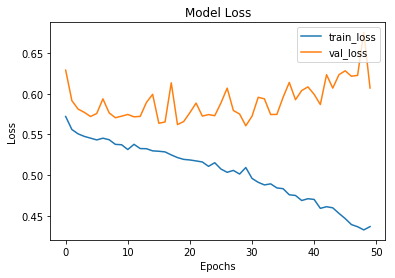

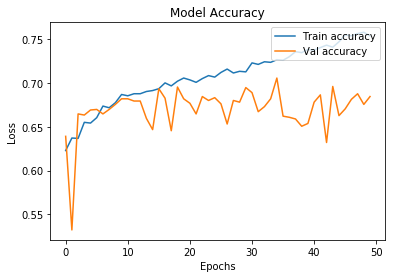

In [28]:
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model.add(MaxPooling2D((2,2), strides=(1,1)))
model.add(Dropout(0.1))
model.add(Conv2D(128, (5, 5), strides=(1, 1), activation="relu", padding="same"))
model.add(Conv2D(256, (5, 5), strides=(1, 1), activation="relu", padding="same"))
model.add(GlobalAveragePooling2D())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

hist=model.fit(x_train, y_train, 
               batch_size=64, 
               epochs=50, 
               verbose=1, 
               class_weight=class_weights, 
               validation_data=(x_val,y_val)
              )


plt.plot(hist.history['loss'],label="train_loss")
plt.plot(hist.history['val_loss'],label="val_loss")
plt.title("Model Loss") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist.history['acc'],label="Train accuracy" )
plt.plot(hist.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

                Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.755877    0.788679  0.771930     0.680166  0.629741   
Confirmed            0.511983    0.465347  0.487552     0.680166  0.629741   

                F1 micro  
False Positive  0.684345  
Confirmed       0.684345  


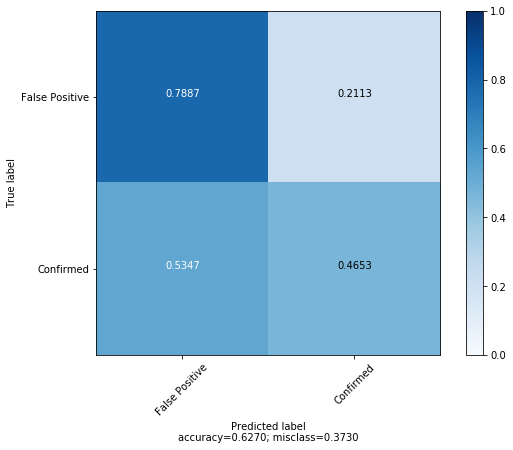

{'Precision raw': array([0.75587703, 0.51198257]), 'Recall raw': array([0.78867925, 0.46534653]), 'F1 raw': array([0.77192982, 0.48755187]), 'F1 weighted': 0.6801656913617545, 'F1 macro': 0.6297408458906603, 'F1 micro': 0.6843450479233227, 'Confusion Matrix': array([[836, 224],
       [270, 235]])}


In [29]:
predichos=model.predict_classes(x_val)
print(calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 100 epochs CNN 9 BCE'))

In [18]:
model = Sequential()
model.add(Dropout(0.2, input_shape=(15,15,1)))
model.add(Conv2D(96, (3, 3), padding='same', activation='relu',kernel_regularizer=l2(0.001)))
model.add(Conv2D(96, (3, 3), padding='same', activation='relu',kernel_regularizer=l2(0.001)))
model.add(Conv2D(96, kernel_size=(3, 3), padding='same',activation='relu', strides=(2,2), kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Conv2D(192, kernel_size=(3, 3), padding='same', activation='relu',kernel_regularizer=l2(0.001)))
model.add(Conv2D(192, kernel_size=(3, 3), padding='same', activation='relu',kernel_regularizer=l2(0.001)))
model.add(Conv2D(192, kernel_size=(3, 3), padding='same',activation='relu', strides = (2,2), kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Conv2D(192, (3, 3), padding='same', activation='relu',kernel_regularizer=l2(0.001)))
model.add(Conv2D(192, (1, 1), padding='same', activation='relu',kernel_regularizer=l2(0.001)))
model.add(Conv2D(10, (1, 1), padding='same', activation='relu',kernel_regularizer=l2(0.001)))
model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

hist=model.fit(x_train, y_train, 
               batch_size=64, 
               epochs=50, 
               verbose=1, 
               class_weight=class_weights, 
               validation_data=(x_val,y_val)
              )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_7 (Dropout)          (None, 15, 15, 1)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 15, 15, 96)        960       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 15, 15, 96)        83040     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 8, 8, 96)          83040     
_________________________________________________________________
dropout_8 (Dropout)          (None, 8, 8, 96)          0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 8, 8, 192)         166080    
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 8, 8, 192)         331968    
__________

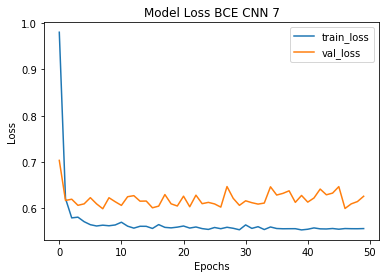

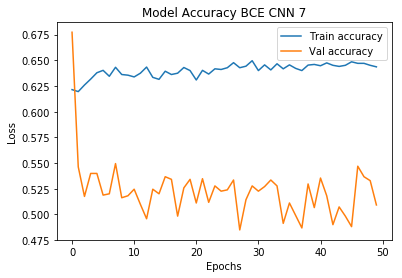

In [20]:
plt.plot(hist.history['loss'],label="train_loss")
plt.plot(hist.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN 7") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist.history['acc'],label="Train accuracy" )
plt.plot(hist.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN 7") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

In [21]:
model.compile(loss='binary_crossentropy',optimizer='sgd',metrics=['accuracy'])

hist=model.fit(x_train, y_train, 
               batch_size=64, 
               epochs=50, 
               verbose=1, 
               class_weight=class_weights, 
               validation_data=(x_val,y_val)
              )

Train on 4692 samples, validate on 1565 samples
Epoch 1/50
4692/4692 [==============================] - 5s 1ms/step - loss: 0.5584 - acc: 0.6428 - val_loss: 0.6747 - val_acc: 0.4435
Epoch 2/50
4692/4692 [==============================] - 4s 914us/step - loss: 0.5601 - acc: 0.6417 - val_loss: 0.6184 - val_acc: 0.5220
Epoch 3/50
4692/4692 [==============================] - 4s 915us/step - loss: 0.5614 - acc: 0.6385 - val_loss: 0.6105 - val_acc: 0.5329
Epoch 4/50
4692/4692 [==============================] - 4s 915us/step - loss: 0.5564 - acc: 0.6370 - val_loss: 0.6056 - val_acc: 0.5361
Epoch 5/50
4692/4692 [==============================] - 4s 933us/step - loss: 0.5601 - acc: 0.6398 - val_loss: 0.6638 - val_acc: 0.4684
Epoch 6/50
4692/4692 [==============================] - 4s 932us/step - loss: 0.5578 - acc: 0.6479 - val_loss: 0.5989 - val_acc: 0.5553
Epoch 7/50
4692/4692 [==============================] - 4s 923us/step - loss: 0.5595 - acc: 0.6379 - val_loss: 0.6021 - val_acc: 0.5399
Ep

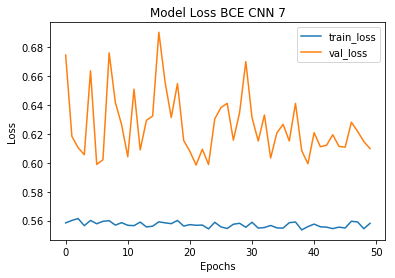

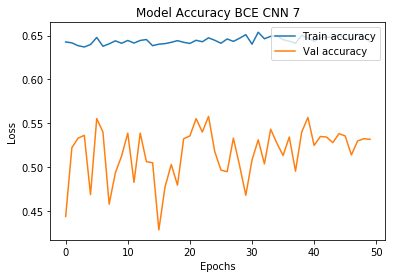

In [23]:
plt.plot(hist.history['loss'],label="train_loss")
plt.plot(hist.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN 7") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist.history['acc'],label="Train accuracy" )
plt.plot(hist.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN 7") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

In [29]:
x_train.shape

(4692, 15, 15, 1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_40 (Dropout)         (None, 15, 15, 1)         0         
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 15, 15, 96)        960       
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 15, 15, 96)        83040     
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 8, 8, 96)          83040     
_________________________________________________________________
dropout_41 (Dropout)         (None, 8, 8, 96)          0         
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 8, 8, 192)         166080    
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 8, 8, 192)         331968    
__________

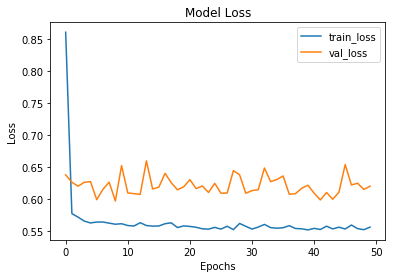

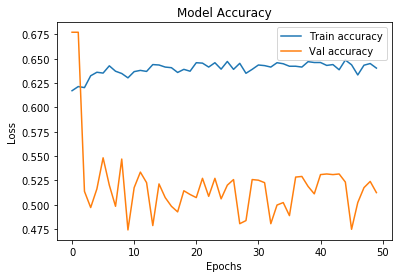

In [38]:
model = Sequential()
model.add(Dropout(0.2, input_shape=(15,15,1)))
model.add(Conv2D(96, (3, 3), padding='same', activation='relu',kernel_regularizer=l2(0.001)))
model.add(Conv2D(96, (3, 3), padding='same', activation='relu',kernel_regularizer=l2(0.001)))
model.add(Conv2D(96, (3, 3), padding='same',activation='relu', strides=(2,2), kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Conv2D(192, (3, 3), padding='same', activation='relu',kernel_regularizer=l2(0.001)))
model.add(Conv2D(192, (3, 3), padding='same', activation='relu',kernel_regularizer=l2(0.001)))
model.add(Conv2D(192, (3, 3), padding='same',activation='relu', strides = (2,2), kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Conv2D(192, (3, 3), padding='same', activation='relu',kernel_regularizer=l2(0.001)))
model.add(Conv2D(192, (3, 3), padding='same', activation='relu',kernel_regularizer=l2(0.001)))
model.add(Conv2D(10, (3, 3), padding='same', activation='relu',kernel_regularizer=l2(0.001)))
model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

hist=model.fit(x_train, y_train, 
               batch_size=64, 
               epochs=50, 
               verbose=1, 
               class_weight=class_weights, 
               validation_data=(x_val,y_val)
              )


plt.plot(hist.history['loss'],label="train_loss")
plt.plot(hist.history['val_loss'],label="val_loss")
plt.title("Model Loss") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist.history['acc'],label="Train accuracy" )
plt.plot(hist.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_249 (Conv2D)          (None, 15, 15, 64)        640       
_________________________________________________________________
conv2d_250 (Conv2D)          (None, 15, 15, 64)        36928     
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_87 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_251 (Conv2D)          (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_252 (Conv2D)          (None, 7, 7, 128)         147584    
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 3, 3, 128)         0         
__________

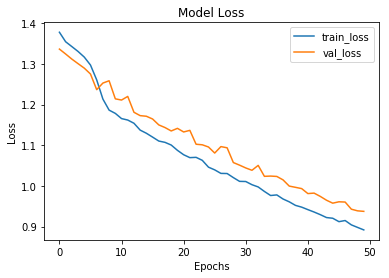

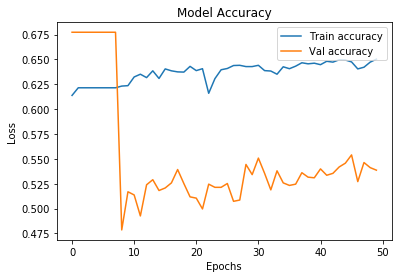

                Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.868996    0.375472  0.524374     0.533324  0.538242   
Confirmed            0.401987    0.881188  0.552109     0.533324  0.538242   

                F1 micro  
False Positive  0.538658  
Confirmed       0.538658  


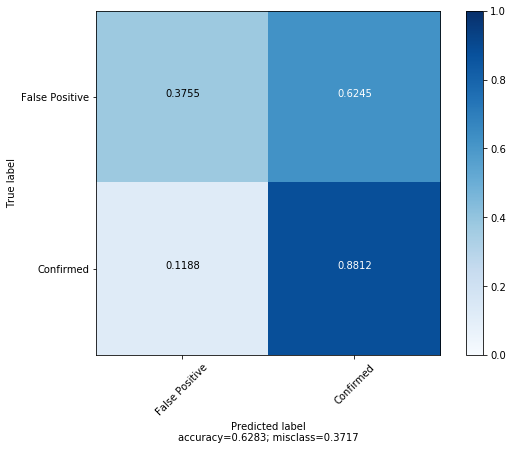

{'Precision raw': array([0.86899563, 0.40198735]), 'Recall raw': array([0.3754717 , 0.88118812]), 'F1 raw': array([0.52437418, 0.55210918]), 'F1 weighted': 0.533323810618148, 'F1 macro': 0.5382416788447644, 'F1 micro': 0.5386581469648563, 'Confusion Matrix': array([[398, 662],
       [ 60, 445]])}


In [74]:
model = Sequential()
model.add(Conv2D(64, 3, input_shape=(15,15,1), strides=1,activation="relu", padding="same",kernel_regularizer=l2(0.001)))
model.add(Conv2D(64, 3, strides=1, activation="relu", padding="same",kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, 3, strides=1, activation="relu", padding="same",kernel_regularizer=l2(0.001)))
model.add(Conv2D(128, 3, strides=1, activation="relu", padding="same",kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, 3, strides=1, activation="relu", padding="same",kernel_regularizer=l2(0.001)))
model.add(Conv2D(256, 3, strides=1, activation="relu", padding="same",kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(GlobalAveragePooling2D())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer=SGD(lr=0.01, momentum=0.9),metrics=['acc'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=5, min_lr=0.0001)
hist=model.fit(x_train, y_train,
               batch_size=128, 
               epochs=50, 
               verbose=0, 
               class_weight=class_weights, 
               callbacks=[reduce_lr],
               validation_data=(x_val,y_val)
              )

plt.plot(hist.history['loss'],label="train_loss")
plt.plot(hist.history['val_loss'],label="val_loss")
plt.title("Model Loss") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist.history['acc'],label="Train accuracy" )
plt.plot(hist.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predichos=model.predict_classes(x_val)
print(calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 100 epochs CNN 9 BCE'))

In [45]:
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model.add(MaxPooling2D((2,2), strides=(1,1)))
model.add(Dropout(0.1))
model.add(Conv2D(128, (5, 5), strides=(1, 1), activation="relu", padding="same"))
model.add(Conv2D(256, (5, 5), strides=(1, 1), activation="relu", padding="same"))
model.add(GlobalAveragePooling2D())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer=SGD(lr=0.01, momentum=0.9),metrics=['acc'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=5, min_lr=0.0001)
hist=model.fit(x_train, y_train,
               batch_size=128, 
               epochs=50, 
               verbose=0, 
               class_weight=class_weights, 
               validation_data=(x_val,y_val)
              )

plt.plot(hist.history['loss'],label="train_loss")
plt.plot(hist.history['val_loss'],label="val_loss")
plt.title("Model Loss") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist.history['acc'],label="Train accuracy" )
plt.plot(hist.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predichos=model.predict_classes(x_val)
print(calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 100 epochs CNN 9 BCE'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_132 (Conv2D)          (None, 15, 15, 64)        640       
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_101 (Dropout)        (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_133 (Conv2D)          (None, 14, 14, 128)       204928    
_________________________________________________________________
conv2d_134 (Conv2D)          (None, 14, 14, 256)       819456    
_________________________________________________________________
global_average_pooling2d_27  (None, 256)               0         
_________________________________________________________________
dense_106 (Dense)            (None, 512)               131584    
__________

KeyboardInterrupt: 

# Con Focal Loss

Train on 4692 samples, validate on 1565 samples
Epoch 1/50
4692/4692 [==============================] - 14s 3ms/step - loss: 0.1519 - acc: 0.6145 - val_loss: 0.1568 - val_acc: 0.5003
Epoch 2/50
4692/4692 [==============================] - 10s 2ms/step - loss: 0.1445 - acc: 0.6272 - val_loss: 0.1561 - val_acc: 0.5150
Epoch 3/50
4692/4692 [==============================] - 10s 2ms/step - loss: 0.1429 - acc: 0.6306 - val_loss: 0.1573 - val_acc: 0.5073
Epoch 4/50
4692/4692 [==============================] - 10s 2ms/step - loss: 0.1431 - acc: 0.6313 - val_loss: 0.1546 - val_acc: 0.5150
Epoch 5/50
4692/4692 [==============================] - 10s 2ms/step - loss: 0.1426 - acc: 0.6319 - val_loss: 0.1537 - val_acc: 0.5227
Epoch 6/50
4692/4692 [==============================] - 10s 2ms/step - loss: 0.1419 - acc: 0.6347 - val_loss: 0.1525 - val_acc: 0.5272
Epoch 7/50
4692/4692 [==============================] - 10s 2ms/step - loss: 0.1412 - acc: 0.6366 - val_loss: 0.1536 - val_acc: 0.5163
Epoch 8

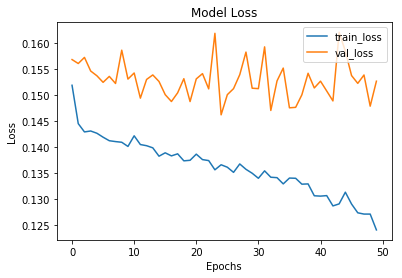

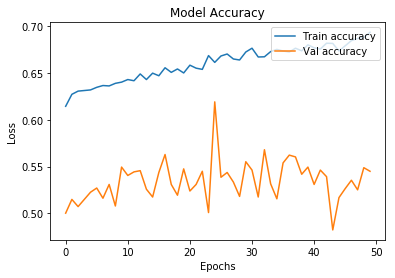

                Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.870213    0.385849  0.534641      0.54121   0.54482   
Confirmed            0.405479    0.879208  0.555000      0.54121   0.54482   

                F1 micro  
False Positive  0.545048  
Confirmed       0.545048  


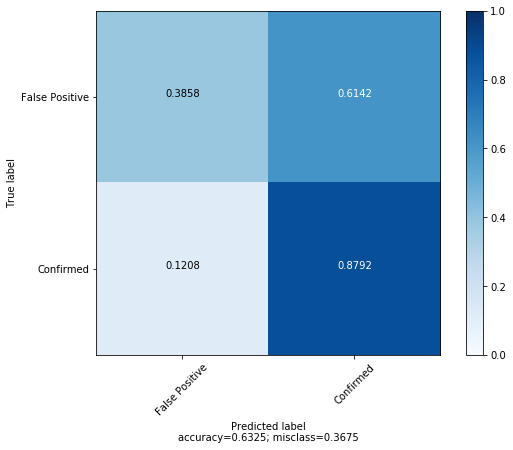

{'Precision raw': array([0.87021277, 0.40547945]), 'Recall raw': array([0.38584906, 0.87920792]), 'F1 raw': array([0.53464052, 0.555     ]), 'F1 weighted': 0.5412101944079016, 'F1 macro': 0.5448202614379085, 'F1 micro': 0.5450479233226837, 'Confusion Matrix': array([[409, 651],
       [ 61, 444]])}


In [46]:
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model.add(MaxPooling2D((2,2), strides=(1,1)))
model.add(Dropout(0.1))
model.add(Conv2D(128, (5, 5), strides=(1, 1), activation="relu", padding="same"))
model.add(Conv2D(256, (5, 5), strides=(1, 1), activation="relu", padding="same"))
model.add(GlobalAveragePooling2D())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss=focal_loss(2,weights=class_weights),optimizer='Adam',metrics=['acc'])
hist=model.fit(x_train, y_train_cat,
               batch_size=128, 
               epochs=50, 
               verbose=1, 
               class_weight=class_weights, 
               validation_data=(x_val,y_val_cat)
              )

plt.plot(hist.history['loss'],label="train_loss")
plt.plot(hist.history['val_loss'],label="val_loss")
plt.title("Model Loss") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist.history['acc'],label="Train accuracy" )
plt.plot(hist.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predichos=model.predict_classes(x_val)
print(calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 100 epochs CNN 9 BCE'))